# Imports

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import linecache
import pandas as pd
from sklearn import preprocessing
from tqdm import trange
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
torch.cuda.set_device(2)
import time
import math

# Help functions

In [2]:
def line_show(line_batch, text=None):
    batch = line_batch["line"][0].shape[0]
    line1 = line_batch["line"][0].numpy().reshape(batch,-1)
    line2 = line_batch["line"][1].numpy().reshape(batch,-1)
    label = line_batch["label"].numpy()
    for i in range(batch):
        ax = plt.subplot(batch/2, 2, i+1)
        plt.subplots_adjust(wspace=0.2, hspace=1.5)
        plt.plot(line1[i])
        plt.plot(line2[i])
        plt.axis
        if text:
            ax.set_title(text+str(label[i]),fontsize=12,color='r')
    
def line_show_test(line_batch, text=None):
    line1 = line_batch[0].numpy().reshape(1,-1)
    line2 = line_batch[1].numpy().reshape(1,-1)
    plt.figure()
    plt.plot(line1[0])
    plt.plot(line2[0])
    if text:
        plt.title(text,fontsize='large',fontweight='bold') 
        
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
    
def read_data_row(path, num):       
    return linecache.getline(path,num)

def normalization(l1, l2):
    pass

# Configuration Class

In [7]:
class Config():
    training_dir = "../data/train/"
    testing_dir = "../data/test/"
    train_val_dir = "../data/train_val/"
    train_batch_size = 32
    train_number_epochs = 30
    train_lr = 0.001
    train_m = 10.0

# Custom Dataset Class

In [4]:
class SkylineDataset(Dataset):
    
    def __init__(self,root,transform=None):
        self.root_path = root
        self.transform = transform
        self.filenames = os.listdir(self.root_path)
    def __getitem__(self,idx):
        filename = self.filenames[idx]
        file = read_data_row(os.path.join(self.root_path, filename), 1).strip().split(" ")
        line1 = np.array(list(map(int, file[0].split(',')))) # C*H*W = (1, 320, 1)
        if self.transform:
            line1 = Move()(line1)
            line1 = Rotate()(line1)
        line2 = np.array(list(map(int, file[1].split(','))))
        line = np.hstack((line1, line2))
        
        line_min, line_max = line.min(), line.max()
        line = (line-line_min)/(line_max-line_min)
        
        line1 = line[:320].reshape(1, 320, 1)
        line2 = line[320:].reshape(1, 320, 1)
        label = np.array(list(map(int, file[2])))
        sample = {"line":[line1, line2], "label":label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return len(self.filenames)
    

In [5]:
class Rotate(object):
    def __call__(self, line):
        angle = random.randint(-6,6)
        pointx = len(line)//2
        pointy = line[pointx]
        angle = float(angle) * 3.1415  / float(180)
        x = np.arange(len(line))
        y = (x-pointx) * math.sin(angle) + (line - pointy) * math.cos(angle) + pointy
        
        return y


class Move(object):
    def __call__(self, line):
        delta = random.randint(-30,30)
        return line + delta
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        line, lable = sample['line'], sample['label']
        return {'line': [torch.from_numpy(line[0]).float(), torch.from_numpy(line[1]).float()],
                'label': torch.from_numpy(lable).float()}

In [8]:
# show
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))


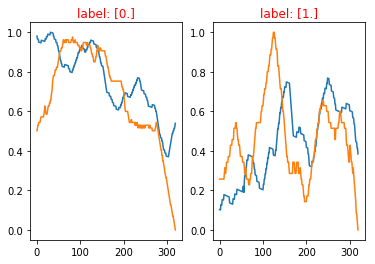

In [10]:
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = 2,
                       num_workers = 0
                       )
dataiter = iter(train_dataloader)
example_batch = next(dataiter)
line_show(example_batch, text="label: ")

# Neural Net Definition

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
              
        self.feature0 = nn.Sequential(
            nn.Conv1d(1, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(48),
            nn.MaxPool1d(kernel_size=2, stride=2), # 48*160
            
            nn.Conv1d(48, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=2), # 128*80
            
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=2, stride=2) # 1*256*40
        )
        
        self.feature1 = nn.Sequential(
            nn.Conv1d(1, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(48),
            nn.MaxPool1d(kernel_size=2, stride=2), # 48*160
            
            nn.Conv1d(48, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=2), # 128*80
            
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=2, stride=2) # 1*256*40
        )
        
                
        self.classify = nn.Sequential(
            nn.Conv1d(512*2, 24, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(24),
            nn.MaxPool1d(kernel_size=2, stride=2),  # N*24*20
            
             nn.Conv1d(24, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*8*10
        )
        

        self.fc = nn.Sequential(
            nn.Linear(80, 1),
            nn.Sigmoid())

    def forward_once(self, x):
        x0 = self.feature0(x)
        x1 = self.feature1(x)
        return torch.cat((x0,x1), 1)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        output = torch.cat((output1, output2), 1)

        output = self.classify(output)
        output = output.view(-1, 1, 80).contiguous()

        output = self.fc(output)
        return output


In [ ]:
from tensorboardX import SummaryWriter
dummy_input0 = torch.rand(32,1, 320) 
dummy_input1 = torch.rand(32,1, 320) 
model = SiameseNetwork()
with SummaryWriter(comment='SiameseNetwork') as w:
    w.add_graph(model, (dummy_input0, dummy_input1))

# Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        euclidean_distance = F.threshold(euclidean_distance, 0.1, 0.0, inplace=False)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # 所有batch的loss

        return loss_contrastive

# Train

In [ ]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [ ]:
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = Config.train_batch_size,
                       num_workers = 0
                       )

In [ ]:
net = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(),lr = Config.train_lr)

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0
best_acc = 0

In [ ]:
def train(epoch):
    net.train()
    for i, data in enumerate(train_dataloader,0):
        line1 = data["line"][0].view(Config.train_batch_size, 1, -1)
        line2 = data["line"][1].view(Config.train_batch_size, 1, -1)
        label = data["label"]
        line1, line2 , label = line1.to(device), line2.to(device) , label.to(device)
        optimizer.zero_grad()
        output = net(line1,line2)
        loss_contrastive = criterion(output,label)
        loss_contrastive.backward()
        optimizer.step()
        
        if i %100 == 0 :
            print("Epoch {} | {} | Current loss {} ".format(epoch, i, loss_contrastive.item()))
            
        

In [ ]:
def test(epoch, path, save=True):
    net.eval()
    
    with torch.no_grad():
        filenames = os.listdir(path)
        acc_top20 = 0
        acc_top50 = 0
        acc_top100 = 0
        acc_top200 = 0
        
        for _ in range(5):
            for i in trange(100):
                index_target = random.randint(0, len(filenames)-1)
                file0 = read_data_row(os.path.join(path, filenames[index_target]), 1).strip().split(" ")
                line0 = np.array(list(map(int, file0[0].split(','))))
                dist = []
                for f in filenames:
                    file1 = read_data_row(os.path.join(path, f), 1).strip().split(" ")
                    line1 = np.array(list(map(int, file1[1].split(','))))
                    line = np.hstack((line0, line1))
                    line_min, line_max = line.min(), line.max()
                    line = (line-line_min)/(line_max-line_min)
                    line1 = torch.from_numpy(line[:320].reshape(1, 1, -1))
                    line2 = torch.from_numpy(line[320:].reshape(1, 1, -1))

                    output = net(Variable(line1).float().to(device), Variable(line2).float().to(device))
                    dist.append(output.item())

                dist = pd.Series(np.array(dist)).sort_values(ascending=False)
                if index_target in dist[:20].index.tolist():
                    acc_top20 += 1
                if index_target in dist[:50].index.tolist():
                    acc_top50 += 1    
                if index_target in dist[:100].index.tolist():
                    acc_top100 += 1
                if index_target in dist[:200].index.tolist():
                    acc_top200 += 1
                
        acc_top20 /= 500.0
        acc_top50 /= 500.0
        acc_top100 /= 500.0
        acc_top200 /= 500.0
        acc_mean = (acc_top20+acc_top50+acc_top100+acc_top200) / 4
        print('epoch %d | acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f' % (epoch, 
                                                                                                    acc_top20, 
                                                                                                    acc_top50,
                                                                                                    acc_top100,
                                                                                                    acc_top200,
                                                                                                    acc_mean))
        
        # saving
        if save:
            global best_acc
            if acc_mean > best_acc:
                print("saving...")
                if not os.path.isdir('./checkpoint'):
                    os.mkdir('./checkpoint')
                time_str = time.strftime("%Y-%m-%d %X",time.localtime())
                torch.save(net.state_dict(), './checkpoint/ckpt.{}.{:.2f}.pth'.format(time_str, acc_mean))
                best_acc = acc_mean
    

In [ ]:
for epoch in range(0,15):
    train(epoch)
    test(epoch, Config.train_val_dir, save=False)
    test(epoch, Config.testing_dir)

# Test

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load("./checkpoint/ckpt.2019-04-24 18:24:29.0.96.pth"))
model.to(device)

In [ ]:
# line probability show
folder_dataset_test = SkylineDataset(root=Config.testing_dir, 
                                transform=transforms.Compose([ToTensor()]))
test_dataloader = DataLoader(folder_dataset_test,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
example0 = next(dataiter)
line0 = example0["line"][0].view(1, 1, -1)
line1 = example0["line"][1].view(1, 1, -1)
label = example0["label"].numpy()
print(label)
for i in range(10):
    output = model(Variable(line0).to(device),Variable(line1).to(device))
    line_show_test((line0, line1, label),'probability: {:.8f}'.format(output.item()))
    
    example1 = next(dataiter)
    line1 = example1["line"][1].view(1, 1, -1)

In [ ]:
# acc inference
model.eval()

with torch.no_grad():
    filenames = os.listdir(Config.testing_dir)
    acc_top5 = 0
    acc_top10 = 0
    acc_top20 = 0
    acc_top50 = 0
    acc_top100 = 0
    acc_top200 = 0

    for i in trange(100):
        index_target = random.randint(0, len(filenames)-1)
        file0 = read_data_row(os.path.join(Config.testing_dir, filenames[index_target]), 1).strip().split(" ")
        line0 = np.array(list(map(int, file0[0].split(','))))
        dist = []
        for f in filenames:
            file1 = read_data_row(os.path.join(Config.testing_dir, f), 1).strip().split(" ")
            line1 = np.array(list(map(int, file1[1].split(','))))
            line = np.hstack((line0, line1))
            line_min, line_max = line.min(), line.max()
            line = (line-line_min)/(line_max-line_min)
            line1 = torch.from_numpy(line[:300].reshape(1, 1, -1))
            line2 = torch.from_numpy(line[300:].reshape(1, 1, -1))

            output = model(Variable(line1).float().to(device), Variable(line2).float().to(device))
            dist.append(output.item())

        dist = pd.Series(np.array(dist)).sort_values(ascending=False)
        if i == 0:
            print(index_target)
            print(dist)
        if index_target in dist[:5].index.tolist():
            acc_top5 += 1
        if index_target in dist[:10].index.tolist():
            acc_top10 += 1    
        if index_target in dist[:20].index.tolist():
            acc_top20 += 1
        if index_target in dist[:50].index.tolist():
            acc_top50 += 1    
        if index_target in dist[:100].index.tolist():
            acc_top100 += 1
        if index_target in dist[:200].index.tolist():
            acc_top200 += 1

    
    acc_top5 /= 100.0
    acc_top10 /= 100.0
    acc_top20 /= 100.0
    acc_top50 /= 100.0
    acc_top100 /= 100.0
    acc_top200 /= 100.0
    acc_mean = (acc_top5+acc_top10+acc_top20+acc_top50+acc_top100+acc_top200) / 6
    pf = 'acc_top5: %.3f |acc_top10: %.3f |acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f'
    print(pf % ( acc_top5,
                 acc_top10,
                 acc_top20, 
                 acc_top50,
                 acc_top100,
                 acc_top200,
                 acc_mean))
